In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline
#%matplotlib widget

In [2]:
import numpy as np
import scipy
import umap
from sklearn.decomposition import PCA
import tqdm

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('bioAI.mplstyle')

import sys
sys.path.append('../') if '../' not in sys.path else None 
from methods import *
from plotting_functions import *

In [3]:
nx,ny = 3,3 # board size
res = 8

# initialize board
xx, yy = np.meshgrid(
    np.linspace(-nx/2, nx/2, res),
    np.linspace(-ny/2, ny/2, res),
)
board = np.stack([xx, yy], axis=-1)

# initialize grid module
T = 1
f = 1/T
orientation_offset = 0
center = np.zeros(2)
#board += center

gridmodule = SquareGridModule(center,orientation_offset,f,non_negative=False,add=True)

In [4]:
phases = gridmodule.inner_square.sample(3,seed=3)
gridmodule.init_module(phases)
ratemaps = gridmodule(board)
phases.shape, ratemaps.shape

((3, 2), (3, 8, 8))

(<Figure size 300x300 with 1 Axes>, <AxesSubplot:>)

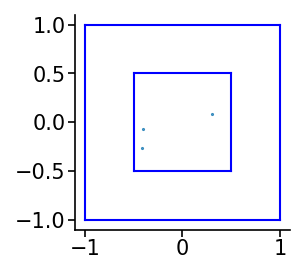

In [5]:
gridmodule.plot(figsize=(2,2))

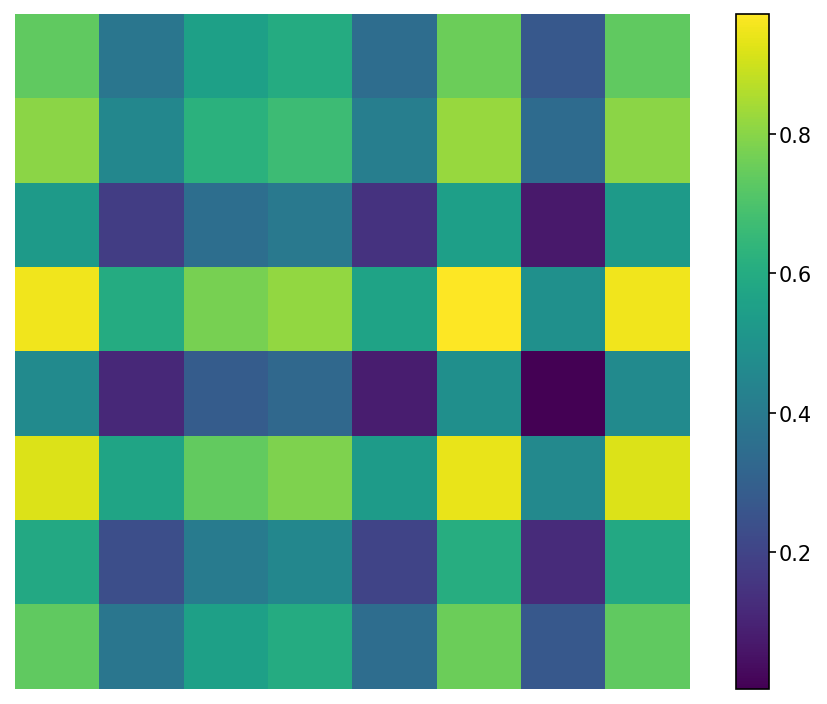

In [6]:
plt.imshow(ratemaps[0])
plt.axis('off')
plt.colorbar()

## Find roots (optimise) of spatial position, given activity

In [7]:
def loss_fn_wrapper(activity, gridmodule):
    # activity: (ncells,)
    def loss_fn(loc):
        return np.sum((gridmodule(loc) - activity)**2)
    return loss_fn

In [8]:
def decode_via_optimisation(activity,gridmodule,x0):
    """
    params:
        activity: (ncells,) grid cells ensemble activity that we want to decode to space 
        gridmodule: Gridmodule object
        x0: initial spatial coordiante to start with (2,)
    """
    loss_fn = loss_fn_wrapper(activity, gridmodule)
    return scipy.optimize.minimize(loss_fn,x0)

In [9]:
spatial_decoding = [[]]*res


label_pos = np.random.uniform(-T/2, T/2, size=2)
label_pos = np.array([0.29187213, -0.18899286])


unit_res = 8
label_poss = np.zeros((unit_res,unit_res,2))
# initialize board
xx, yy = np.meshgrid(
    np.linspace(-T/2, T/2, unit_res),
    np.linspace(-T/2, T/2, unit_res),
)
unit_cell_grid = np.stack([xx, yy], axis=-1)


for x in range(res):
    for y in tqdm.trange(res):
        label_pos = unit_cell_grid[x,y]
        label_poss[x,y] = label_pos
        activity = gridmodule(label_pos)

        decoded_pos = np.zeros_like(board)
        for i in range(res):
            for j in range(res):
                decoded_pos[i,j] = decode_via_optimisation(activity,gridmodule,board[i,j]).x

        decoded_modulo_pos = (decoded_pos + 0.5*T) % T
        decoded_modulo_pos -= 0.5*T
                
        unique_counts = np.unique(np.around(decoded_modulo_pos,decimals=4).reshape(-1,2),axis=0, return_counts=True)
        spatial_decoding[x].append(unique_counts)

100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  6.72it/s]


In [10]:
spatial_decoding[0][0]

(array([[-0.5   , -0.5   ],
        [-0.5   ,  0.5   ],
        [-0.0718, -0.2054],
        [ 0.5   , -0.5   ],
        [ 0.5   ,  0.5   ]]),
 array([ 5, 23, 20, 13,  3]))

In [11]:
#-0.24187328,  0.075241 leads to 0.29187213, -0.18899286
# 0.29187213, -0.18899286 leads to -0.47272336,  0.24432241
# => non-symmetrical solutions?

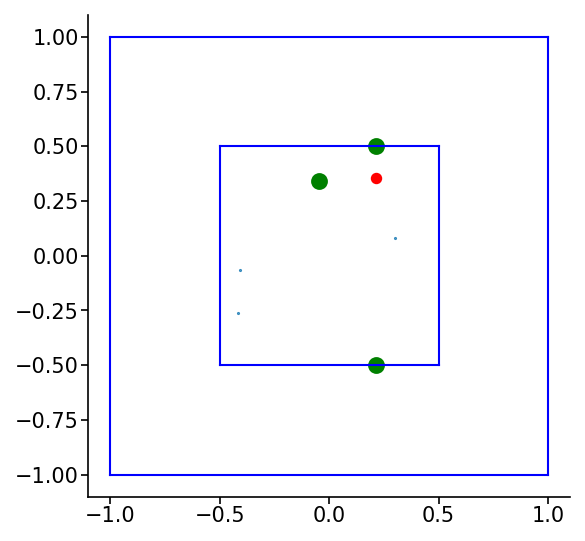

In [12]:
fig, ax = gridmodule.plot(figsize=(4,4))
x,y = 6,5
ax.scatter(*spatial_decoding[x][y][0].reshape(-1,2).T, s=50, color='green')#, label='pred')
ax.scatter(*label_poss[x,y], s=20, color='red')#, label='true')
#ax.legend()
#ax.axis('off')

### 